# Experiment: Used-device pricing (EDA, Regression, Classification)
One-line: Load dataset, run EDA, train regression to predict `listed_price` and a binary classifier for high/low price; compute multiple metrics & save models.


In [29]:
# Cell 1 - Imports & setup
# (One-line) Import libraries and set plotting style.
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
import joblib
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


In [31]:
# Cell 2 - Load dataset (auto-find)
# (One-line) Try to locate 'used_device_data.csv' under data/raw or data and load it.
search_paths = [Path("data/raw"), Path("data"), Path(".")]
DATA_PATH = None
for p in search_paths:
    if p.exists():
        for f in p.glob("*.csv"):
            name = f.name.lower()
            if "used" in name or "device" in name or "listings" in name:
                DATA_PATH = f
                break
    if DATA_PATH:
        break

if DATA_PATH is None:
    # fallback - explicit path (edit if your file is in a different location)
    DATA_PATH = Path("../../data/raw/used_device_data.csv")

print("Using dataset:", DATA_PATH)
df = pd.read_csv(DATA_PATH)
df.head()


Using dataset: ..\..\data\raw\used_device_data.csv


,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


In [32]:
# Cell 3 - Quick EDA summary
# (One-line) Show shape, dtypes, missing value counts and basic stats.
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nMissing values:\n", df.isna().sum())
display(df.describe(include="all").T)


Shape: (3454, 15)

Dtypes:
 device_brand              object
os                        object
screen_size              float64
4g                        object
5g                        object
rear_camera_mp           float64
front_camera_mp          float64
internal_memory          float64
ram                      float64
battery                  float64
weight                   float64
release_year               int64
days_used                  int64
normalized_used_price    float64
normalized_new_price     float64
dtype: object

Missing values:
 device_brand               0
os                         0
screen_size                0
4g                         0
5g                         0
rear_camera_mp           179
front_camera_mp            2
internal_memory            4
ram                        4
battery                    6
weight                     7
release_year               0
days_used                  0
normalized_used_price      0
normalized_new_price       0
dtype: int

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
device_brand,3454,34,Others,502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
os,3454,4,Android,3214,NaN,NaN,NaN,NaN,NaN,NaN,NaN
screen_size,3454.0,NaN,NaN,NaN,13.713115,3.80528,5.08,12.7,12.83,15.34,30.71
4g,3454,2,yes,2335,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5g,3454,2,no,3302,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rear_camera_mp,3275.0,NaN,NaN,NaN,9.460208,4.815461,0.08,5.0,8.0,13.0,48.0
front_camera_mp,3452.0,NaN,NaN,NaN,6.554229,6.970372,0.0,2.0,5.0,8.0,32.0
internal_memory,3450.0,NaN,NaN,NaN,54.573099,84.972371,0.01,16.0,32.0,64.0,1024.0
ram,3450.0,NaN,NaN,NaN,4.036122,1.365105,0.02,4.0,4.0,4.0,12.0
battery,3448.0,NaN,NaN,NaN,3133.402697,1299.682844,500.0,2100.0,3000.0,4000.0,9720.0


In [33]:
# Cell 4 - Cleaning & target creation
# (One-line) Do simple cleaning, drop exact duplicates, and create regression + binary classification targets.
df = df.copy()
df.drop_duplicates(inplace=True)
# if columns have spaces or odd names, normalize them
df.columns = [c.strip() for c in df.columns]

# Choose regression target: normalized_used_price if present else listed_price/original_price
if "normalized_used_price" in df.columns:
    y_reg_name = "normalized_used_price"
elif "listed_price" in df.columns:
    y_reg_name = "listed_price"
elif "original_price" in df.columns:
    y_reg_name = "original_price"
else:
    raise RuntimeError("No suitable regression price column found. Edit cell to point to price column.")

# Classification target: binary high/low priced vs median
df = df.dropna(subset=[y_reg_name])  # require price present
median_price = df[y_reg_name].median()
df["high_value"] = (df[y_reg_name] >= median_price).astype(int)

print("Regression target:", y_reg_name)
print("Created classification target 'high_value' using median =", median_price)
df[[y_reg_name, "high_value"]].describe()


Regression target: normalized_used_price
Created classification target 'high_value' using median = 4.405132623


,normalized_used_price,high_value
count,3454.000000,3454.000000
mean,4.364712,0.500290
std,0.588914,0.500072
min,1.536867,0.000000
25%,4.033931,0.000000
50%,4.405133,1.000000
75%,4.755700,1.000000
max,6.619433,1.000000


In [34]:
# Cell 5 - Feature selection
# (One-line) Auto-select numeric and categorical features excluding target columns.
exclude = {y_reg_name, "high_value"}
all_cols = df.columns.tolist()
# pick numeric-like columns
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
# remove targets from numeric features
numeric_features = [c for c in numeric_features if c not in exclude]
# categorical features are objects that are not targets
categorical_features = [c for c in all_cols if c not in numeric_features + list(exclude)]
# sometimes id-like columns present: remove obvious id columns
categorical_features = [c for c in categorical_features if not c.lower().endswith("id")]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['screen_size', 'rear_camera_mp', 'front_camera_mp', 'internal_memory', 'ram', 'battery', 'weight', 'release_year', 'days_used', 'normalized_new_price']
Categorical features: ['device_brand', 'os', '4g', '5g']


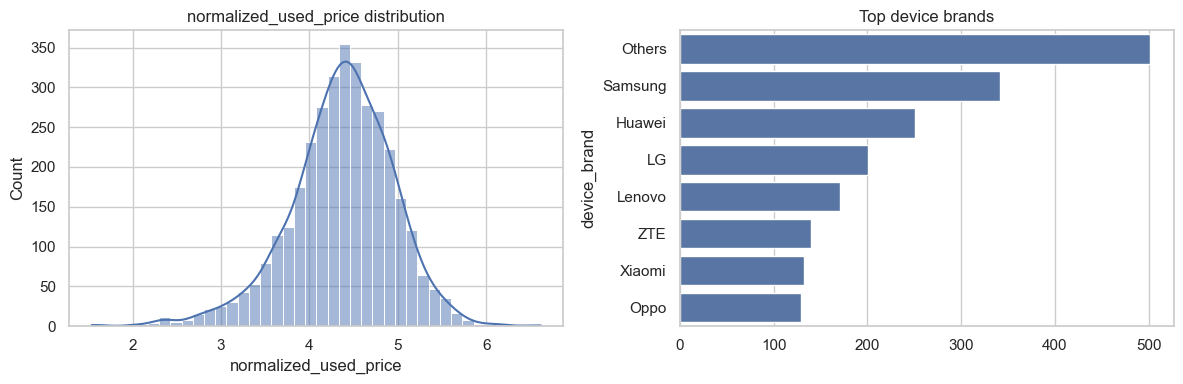

In [35]:
# Cell 6 - Quick visual EDA
# (One-line) Show histograms of the price and countplot of top brands (if present).
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df[y_reg_name].dropna(), bins=40, kde=True)
plt.title(f"{y_reg_name} distribution")

plt.subplot(1,2,2)
if "device_brand" in df.columns:
    top = df["device_brand"].value_counts().nlargest(8)
    sns.barplot(x=top.values, y=top.index)
    plt.title("Top device brands")
else:
    plt.text(0.5, 0.5, "No 'device_brand' column", ha="center")
plt.tight_layout()


In [36]:
# Cell 7 - Preprocessing pipeline
# (One-line) Create ColumnTransformer: StandardScale numeric, OneHotEncode categorical.
# NOTE: sklearn OneHotEncoder uses sparse_output in recent versions; use sparse_output=False for dense arrays.
cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, numeric_features),
        ("cat", cat_transformer, categorical_features)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# quick test of preprocessor fit_transform shape (on a small subset)
if len(df) > 10:
    sample = df.head(10)
else:
    sample = df
try:
    _ = preprocessor.fit_transform(sample.drop(columns=[y_reg_name,"high_value"]))
    print("Preprocessor OK")
except Exception as e:
    print("Preprocessor fit error (run later after checking features):", e)


Preprocessor OK


In [45]:
# Cell 8 - Train/test split
# (One-line) Create X matrix and split both regression and classification targets.
X = df.drop(columns=[y_reg_name, "high_value"])
y_reg = df[y_reg_name].values
y_clf = df["high_value"].values

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42
)

print("Shapes - X_train_reg:", X_train_reg.shape, "X_test_reg:", X_test_reg.shape)


Shapes - X_train_reg: (2763, 14) X_test_reg: (691, 14)


In [54]:
# show shape and NaN counts in training features and target
print("X_train_reg type:", type(X_train_reg))
try:
    dfX = X_train_reg if hasattr(X_train_reg, "isna") else pd.DataFrame(X_train_reg, columns=feature_cols)
except Exception:
    # fallback: coerce to DataFrame without column names
    dfX = pd.DataFrame(X_train_reg)
print("X_train_reg shape:", dfX.shape)
print(dfX.isna().sum().sort_values(ascending=False).head(30))
print("Total NaNs in X_train_reg:", dfX.isna().sum().sum())
print("y_train_reg NaNs:", pd.isna(y_train_reg).sum())


X_train_reg type: <class 'pandas.core.frame.DataFrame'>
X_train_reg shape: (2763, 14)
rear_camera_mp          139
weight                    6
ram                       4
battery                   4
internal_memory           4
front_camera_mp           1
5g                        0
4g                        0
screen_size               0
os                        0
device_brand              0
release_year              0
days_used                 0
normalized_new_price      0
dtype: int64
Total NaNs in X_train_reg: 158
y_train_reg NaNs: 0


In [55]:
# imports (run if not already)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Choose numeric and categorical columns explicitly from your DataFrame (adjust names if needed)
# If you have a DataFrame dfX from Cell A, we can auto-detect:
num_cols = dfX.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in dfX.columns.tolist() if c not in num_cols]

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# Transformers
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
    # modern sklearn uses sparse_output instead of sparse
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
    ],
    verbose_feature_names_out=False,
    remainder="drop",
)


Numeric cols: ['screen_size', 'rear_camera_mp', 'front_camera_mp', 'internal_memory', 'ram', 'battery', 'weight', 'release_year', 'days_used', 'normalized_new_price']
Categorical cols: ['device_brand', 'os', '4g', '5g']


In [56]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# pipelines
reg_lr = Pipeline([("pre", preprocessor), ("lr", LinearRegression())])
reg_rf = Pipeline([("pre", preprocessor), ("rf", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))])

# if X_train_reg is ndarray convert to DataFrame for consistent column mapping
if not hasattr(X_train_reg, "columns"):
    X_train_reg_df = pd.DataFrame(X_train_reg, columns=dfX.columns)
    X_test_reg_df = pd.DataFrame(X_test_reg, columns=dfX.columns)
else:
    X_train_reg_df = X_train_reg
    X_test_reg_df = X_test_reg

# Double-check NaNs BEFORE fit — preprocessor will handle NaNs, but let's confirm
print("Pre-fit NaNs (train):", X_train_reg_df.isna().sum().sum(), " (test):", X_test_reg_df.isna().sum().sum())

# Fit — preprocessor includes imputers so estimator won't see NaNs
print("Fitting LinearRegression...")
reg_lr.fit(X_train_reg_df, y_train_reg)
print("Fitting RandomForestRegressor...")
reg_rf.fit(X_train_reg_df, y_train_reg)
print("Done: models fitted.")


Pre-fit NaNs (train): 158  (test): 44
Fitting LinearRegression...
Fitting RandomForestRegressor...
Done: models fitted.


In [58]:
# cell: Evaluate & save (replacement for the previous cell that used squared=)
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os

# defensive: ensure y arrays are 1-D numeric numpy arrays
y_true = np.asarray(y_test_reg).ravel().astype(float)
pred_lr_arr = np.asarray(pred_lr).ravel().astype(float)
pred_rf_arr = np.asarray(pred_rf).ravel().astype(float)

def print_reg_metrics(y_true, y_pred, name="model"):
    mse = mean_squared_error(y_true, y_pred)        # MSE
    rmse = float(np.sqrt(mse))                     # RMSE
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

print_reg_metrics(y_true, pred_lr_arr, "LinearRegression")
print_reg_metrics(y_true, pred_rf_arr, "RandomForest")

# save model directory
os.makedirs("models", exist_ok=True)
joblib.dump(reg_rf, "models/regressor_random_forest.pkl")
print("Saved models/regressor_random_forest.pkl")


LinearRegression -> RMSE: 0.231, MAE: 0.184, R2: 0.836
RandomForest -> RMSE: 0.218, MAE: 0.175, R2: 0.854
Saved models/regressor_random_forest.pkl


In [59]:
# Cell 9 - Train regressors
# (One-line) Build pipelines and fit LinearRegression and RandomForestRegressor.
reg_lr = Pipeline([("pre", preprocessor), ("lr", LinearRegression())])
reg_rf = Pipeline([("pre", preprocessor), ("rf", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))])

print("Fitting LinearRegression...")
reg_lr.fit(X_train_reg, y_train_reg)
print("Fitting RandomForestRegressor...")
reg_rf.fit(X_train_reg, y_train_reg)
print("Regression models fitted.")


Fitting LinearRegression...
Fitting RandomForestRegressor...
Regression models fitted.


== LinearRegression ==
R2: 0.835728793825748
RMSE: 0.23088751323969622
MAE: 0.18437999841091723
== RandomForestRegressor ==
R2: 0.8540689492319745
RMSE: 0.21761738035397202
MAE: 0.17497687638237328


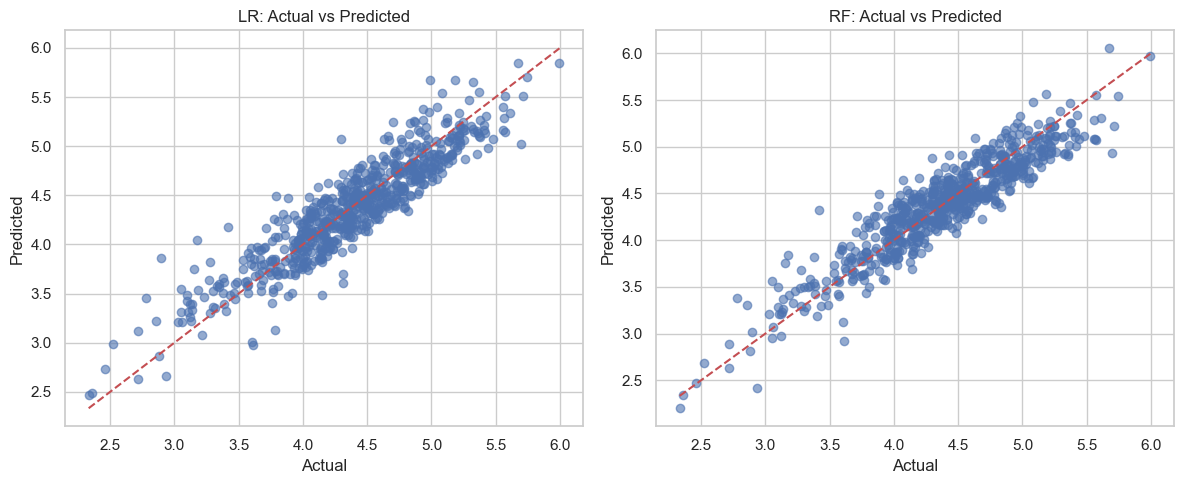

In [60]:
# Cell 10 - Regression evaluation
# (One-line) Evaluate models using R2, RMSE, MAE and show predicted vs actual scatter.
def reg_metrics(model, X_test, y_test, name="model"):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"== {name} ==")
    print("R2:", r2)
    print("RMSE:", rmse)
    print("MAE:", mae)
    return y_pred

y_pred_lr = reg_metrics(reg_lr, X_test_reg, y_test_reg, "LinearRegression")
y_pred_rf = reg_metrics(reg_rf, X_test_reg, y_test_reg, "RandomForestRegressor")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_test_reg, y_pred_lr, alpha=0.6); plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], "r--")
plt.title("LR: Actual vs Predicted"); plt.xlabel("Actual"); plt.ylabel("Predicted")

plt.subplot(1,2,2)
plt.scatter(y_test_reg, y_pred_rf, alpha=0.6); plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], "r--")
plt.title("RF: Actual vs Predicted"); plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.tight_layout()


In [61]:
# Cell 11 - Train classifiers
# (One-line) Fit Logistic Regression and RandomForestClassifier pipelines for classification.
clf_lr = Pipeline([("pre", preprocessor), ("clf", LogisticRegression(max_iter=1000))])
clf_rf = Pipeline([("pre", preprocessor), ("clf", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])

clf_lr.fit(X_train_clf, y_train_clf)
clf_rf.fit(X_train_clf, y_train_clf)
print("Classification models fitted.")


Classification models fitted.


== LogisticRegression ==
Accuracy: 0.8769898697539797
Precision: 0.8640226628895185
Recall: 0.8918128654970761
F1: 0.8776978417266187
AUC: 0.9576819316677558
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88       349
           1       0.86      0.89      0.88       342

    accuracy                           0.88       691
   macro avg       0.88      0.88      0.88       691
weighted avg       0.88      0.88      0.88       691



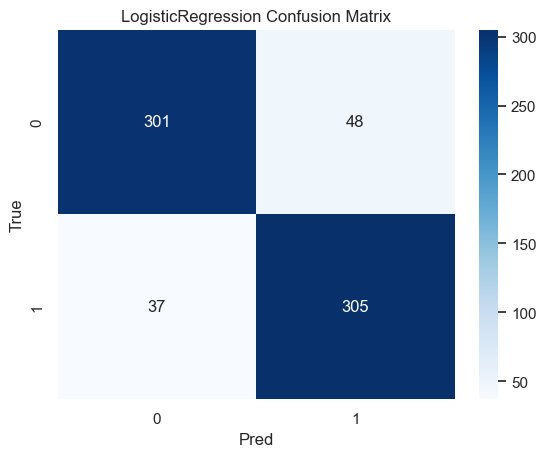

== RandomForestClassifier ==
Accuracy: 0.874095513748191
Precision: 0.8551532033426184
Recall: 0.8976608187134503
F1: 0.8758915834522111
AUC: 0.9488890564520183
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87       349
           1       0.86      0.90      0.88       342

    accuracy                           0.87       691
   macro avg       0.87      0.87      0.87       691
weighted avg       0.88      0.87      0.87       691



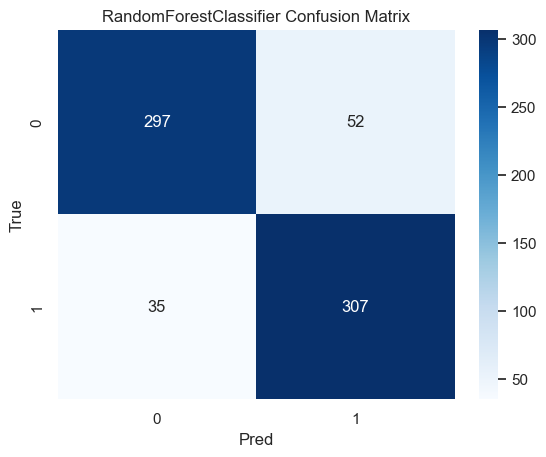

In [62]:
# Cell 12 - Classification evaluation
# (One-line) Evaluate models: accuracy, precision, recall, f1, roc-auc and confusion matrix.
def clf_metrics(model, X_test, y_test, name="clf"):
    y_pred = model.predict(X_test)
    y_prob = None
    try:
        y_prob = model.predict_proba(X_test)[:,1]
    except:
        try:
            y_prob = model.decision_function(X_test)
        except:
            y_prob = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    print(f"== {name} ==")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1:", f1)
    print("AUC:", auc)
    print("Classification report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.show()

clf_metrics(clf_lr, X_test_clf, y_test_clf, "LogisticRegression")
clf_metrics(clf_rf, X_test_clf, y_test_clf, "RandomForestClassifier")


In [63]:
# Cell 13 - Cross-validation & feature importance
# (One-line) Run CV for RF regressor (R2) and display top feature importances for RF classifier/regressor.
print("RF regressor CV R2 (5-fold):")
cv_r2 = cross_val_score(reg_rf, X, y_reg, cv=5, scoring="r2", n_jobs=-1)
print(cv_r2, "mean:", cv_r2.mean())

# feature importance for random forest classifier/regressor - need preprocessor -> use pipeline steps
def get_feature_names(preprocessor):
    # numeric names
    num_names = numeric_features
    cat_names = []
    if hasattr(preprocessor, "named_transformers_"):
        cat_t = preprocessor.named_transformers_.get("cat")
        if cat_t is not None:
            try:
                cat_names = list(cat_t.get_feature_names_out(categorical_features))
            except:
                # fallback
                cat_names = categorical_features
    return num_names + cat_names

feat_names = get_feature_names(preprocessor)
if hasattr(clf_rf.named_steps["clf"], "feature_importances_"):
    importances = clf_rf.named_steps["clf"].feature_importances_
    top_idx = np.argsort(importances)[::-1][:20]
    top_feats = [(feat_names[i] if i < len(feat_names) else f"f{i}", importances[i]) for i in top_idx]
    print("Top feature importances (classifier):")
    for fn, imp in top_feats[:10]:
        print(fn, round(imp,4))


RF regressor CV R2 (5-fold):
[0.86737076 0.81519002 0.8412065  0.81115374 0.85666843] mean: 0.8383178888422085
Top feature importances (classifier):
normalized_new_price 0.2012
battery 0.1163
screen_size 0.1116
weight 0.0978
front_camera_mp 0.0825
rear_camera_mp 0.0814
days_used 0.0621
internal_memory 0.0575
release_year 0.0352
4g_no 0.0296


In [65]:
# Cell 14 - Save models & preprocessor
# (One-line) Save preprocessor and chosen best models to ml/ as joblib files.
out_dir = Path("ml")
out_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(preprocessor, out_dir / "preprocessor.joblib")
joblib.dump(reg_rf, out_dir / "regression_rf_model.joblib")
joblib.dump(clf_rf, out_dir / "classification_rf_model.joblib")

print("Saved: preprocessor.joblib, regression_rf_model.joblib, classification_rf_model.joblib in", out_dir.resolve())


Saved: preprocessor.joblib, regression_rf_model.joblib, classification_rf_model.joblib in C:\Users\user\OneDrive\Documents\GitHub\smart-circular-ewaste-platform\ml\notebooks\ml


In [67]:
# Cell 15 - Example load & predict
# (One-line) Demonstrate loading preprocessor and model and predicting on a single example row.
pp = joblib.load("ml/preprocessor.joblib")
model_reg = joblib.load("ml/regression_rf_model.joblib")
model_clf = joblib.load("ml/classification_rf_model.joblib")

sample = X.iloc[0:1]  # first row as example
pred_price = model_reg.predict(sample)[0]
pred_high = model_clf.predict(sample)[0]
print("Example sample index:", sample.index[0])
print("Predicted price:", pred_price)
print("Predicted high_value (1=high):", pred_high)


Example sample index: 0
Predicted price: 4.378119216475005
Predicted high_value (1=high): 1
